In [160]:
import numpy as np
import pickle
import os
import re
import pandas as pd
import tqdm
import glob

import sys
sys.path.append("../../scripts")

import matplotlib.pyplot as plt

from scripts.run_bubblewrap import BubblewrapRun

In [250]:
files = glob.glob("*pickle")
files.sort()
files[-2:]

['bubblewrap_run_2023-04-25-14-31-16.pickle',
 'bubblewrap_run_2023-04-25-14-31-40.pickle']

In [163]:
file = 'bubblewrap_run_2023-04-25-12-47-56.pickle'
file

'bubblewrap_run_2023-04-25-12-47-56.pickle'

In [164]:
with open(file, "rb") as fhan:
    br = pickle.load(fhan)
    if br.bw_parameters and "seed" not in br.bw_parameters:
        br.bw_parameters["seed"] = 42

In [245]:
for key, value in br.bw_parameters.items():
    print(f"{key}: {value}")
print(f"input file: {br.file}")
print(f"savefile: {br.outfile}")

num: 8
lam: 0.001
nu: 0.001
eps: 0.001
step: 0.08
M: 100
B_thresh: -5
batch: False
batch_size: 1
go_fast: False
lookahead_steps: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
seed: 42
input file: ./generated/clock-steadier_farther.npz
savefile: generated/bubblewrap_runs/bubblewrap_run_2023-04-25-12-47-56.pickle


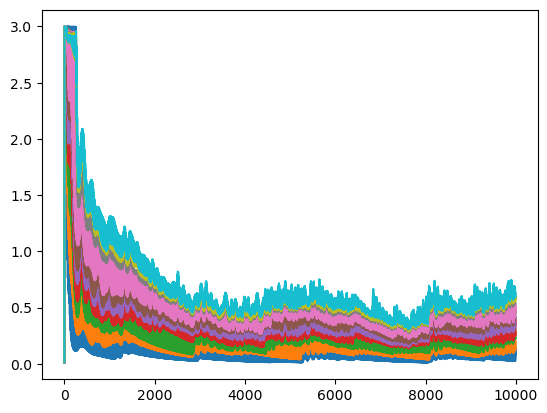

In [166]:
%matplotlib inline
plt.plot(br.entropy_list);


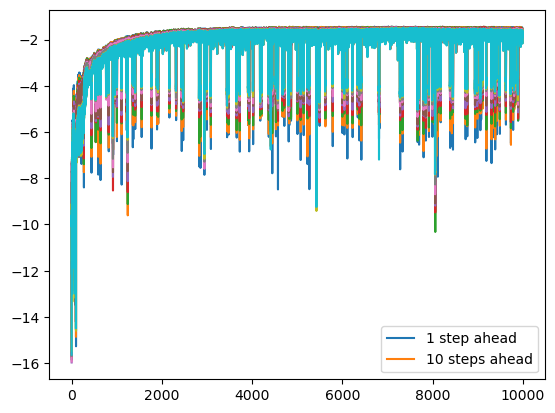

In [167]:
plt.plot(br.pred_list)
plt.legend(["1 step ahead", "10 steps ahead"])

In [169]:
pp_means = []
ent_means = []
for i, step in enumerate(br.bw_parameters["lookahead_steps"]):
    pp_means.append(np.mean(br.pred_list[-T//2:,i]))
    print(f"pred. prob. {step:>2} step(s) ahead mean: {pp_means[-1]}")
    
for i, step in enumerate(br.bw_parameters["lookahead_steps"]):
    ent_means.append(np.mean(br.entropy_list[-T//2:,i]))
    print(f"entropy     {step:>2} step(s) ahead mean: {ent_means[-1]}")


pred. prob.  1 step(s) ahead mean: -1.8981919288635254
pred. prob.  2 step(s) ahead mean: -1.9516724348068237
pred. prob.  3 step(s) ahead mean: -1.998059630393982
pred. prob.  4 step(s) ahead mean: -2.0400617122650146
pred. prob.  5 step(s) ahead mean: -2.0764687061309814
pred. prob.  6 step(s) ahead mean: -2.1107215881347656
pred. prob.  7 step(s) ahead mean: -2.1440515518188477
pred. prob.  8 step(s) ahead mean: -2.1740026473999023
pred. prob.  9 step(s) ahead mean: -2.2133712768554688
pred. prob. 10 step(s) ahead mean: -2.2410123348236084
entropy      1 step(s) ahead mean: 0.13968108594417572
entropy      2 step(s) ahead mean: 0.2351386994123459
entropy      3 step(s) ahead mean: 0.31665197014808655
entropy      4 step(s) ahead mean: 0.388797789812088
entropy      5 step(s) ahead mean: 0.45365679264068604
entropy      6 step(s) ahead mean: 0.5134363770484924
entropy      7 step(s) ahead mean: 0.5693061947822571
entropy      8 step(s) ahead mean: 0.6215800642967224
entropy      9 st

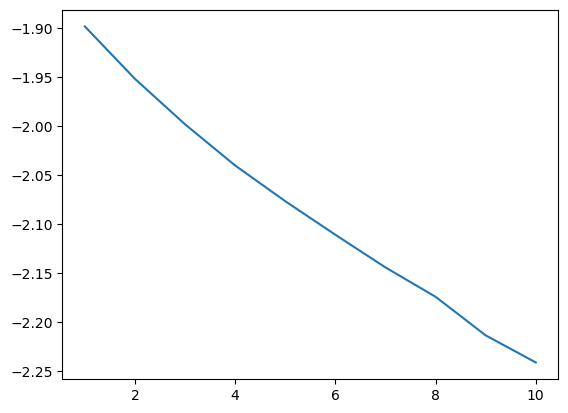

In [170]:
plt.plot(br.bw_parameters["lookahead_steps"], pp_means)

# Comparing new and old forcasting metrics

In [430]:
# new_way_file = 'bubblewrap_run_2023-04-25-12-50-46.pickle' # fast and separated
# old_way_file = 'bubblewrap_run_2023-04-25-12-55-59.pickle'

# new_way_file = 'bubblewrap_run_2023-04-25-13-05-20.pickle' # slow and separated
# old_way_file = 'bubblewrap_run_2023-04-25-13-06-21.pickle'

# new_way_file = 'bubblewrap_run_2023-04-25-13-12-25.pickle' # .5-speed and separated
# old_way_file = 'bubblewrap_run_2023-04-25-13-13-57.pickle'

old_way_file = 'bubblewrap_run_2023-04-25-15-44-11.pickle' # shuffled
new_way_file = 'bubblewrap_run_2023-04-25-15-44-56.pickle'


# old_way_file = 'bubblewrap_run_2023-04-25-14-31-16.pickle' # monkey reach
# new_way_file = 'bubblewrap_run_2023-04-25-14-31-40.pickle'

old_way_file = 'bubblewrap_run_2023-04-25-14-52-37.pickle' # neuropixel
new_way_file = 'bubblewrap_run_2023-04-25-15-15-23.pickle'



with open(new_way_file, "rb") as fhan:
    new_way_br = pickle.load(fhan)

with open(old_way_file, "rb") as fhan:
    old_way_br = pickle.load(fhan)

In [431]:
for key, value in new_way_br.bw_parameters.items():
    print(f"{key}: {value}")
print(f"input file: {new_way_br.file}")
print(f"savefile: {new_way_br.outfile}")

num: 200
lam: 0.001
nu: 0.001
eps: 0.001
step: 0.08
M: 30
B_thresh: -10
batch: False
batch_size: 1
go_fast: False
lookahead_steps: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 30]
seed: 42
input file: ./generated/neuropixel_reduced.npz
savefile: generated/bubblewrap_runs/bubblewrap_run_2023-04-25-15-15-23.pickle


In [432]:
T = new_way_br.pred_list.shape[0]
new_way_means = []
old_way_means = []
for i, step in enumerate(new_way_br.bw_parameters["lookahead_steps"]):
    new_way_means.append(np.mean(new_way_br.pred_list[-T//2:,i]))
    # print(f"new way {step:>2} step(s) ahead mean: {new_way_means[-1]}")

for i, step in enumerate(old_way_br.bw_parameters["lookahead_steps"]):
    old_way_means.append(np.mean(old_way_br.pred_list[-T//2:,i]))
    # print(f"old way {step:>2} step(s) ahead mean: {old_way_means[-1]}")

In [433]:
assert np.all(new_way_br.entropy_list == old_way_br.entropy_list)
assert np.all((new_way_br.pred_list == old_way_br.pred_list)[:,0])
assert new_way_br.bw_parameters["lookahead_steps"] == old_way_br.bw_parameters["lookahead_steps"]
print((new_way_br.pred_list == old_way_br.pred_list)[:,1:].mean())

2.9364982258656552e-05


Text(0.5, 0, 'number of steps ahead predicted')

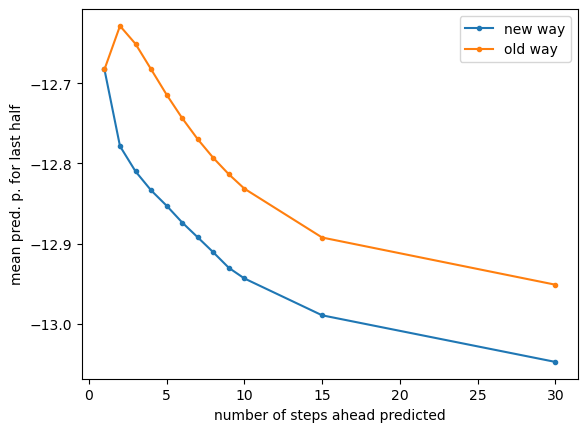

In [437]:
plt.plot(new_way_br.bw_parameters["lookahead_steps"], new_way_means, '.-')
plt.plot(new_way_br.bw_parameters["lookahead_steps"], old_way_means,'.-')
plt.legend(["new way", "old way"])
plt.ylabel("mean pred. p. for last half")
plt.xlabel("number of steps ahead predicted")

In [435]:
s = np.sort(np.abs(np.linalg.eigvals(old_way_br.A)))[::-1]
plt.plot(s,'.')

In [399]:
np.abs(s).shape

(200,)

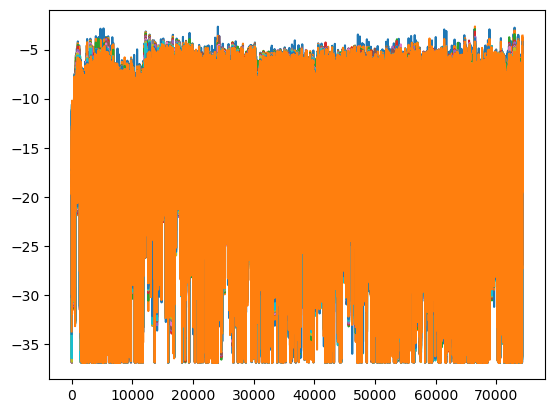

In [436]:
%matplotlib inline
plt.plot(new_way_br.pred_list)

[]

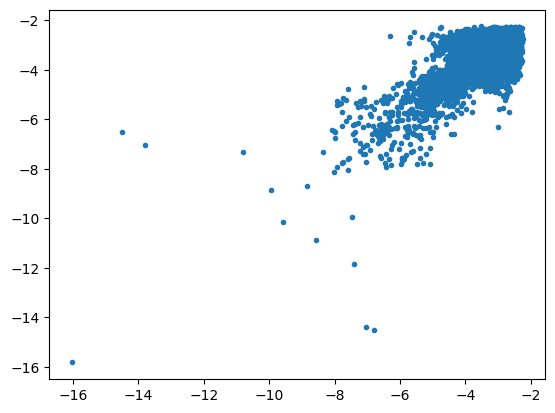

In [369]:
%matplotlib inline
s = 2
i = new_way_br.bw_parameters["lookahead_steps"].index(s)
plt.plot(new_way_br.pred_list[:,i], old_way_br.pred_list[:,i],'.')
plt.plot()
# plt.plot(new_way_br.bw_parameters["lookahead_steps"], old_way_means,'.-')
# plt.legend(["new way", "old way"])

[]

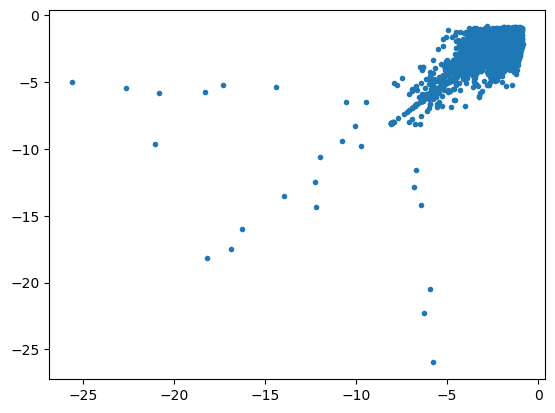

In [329]:
%matplotlib inline
s = 2
i = new_way_br.bw_parameters["lookahead_steps"].index(s)
plt.plot(new_way_br.pred_list[:,i], old_way_br.pred_list[:,i],'.')
plt.plot()
# plt.plot(new_way_br.bw_parameters["lookahead_steps"], old_way_means,'.-')
# plt.legend(["new way", "old way"])

[]

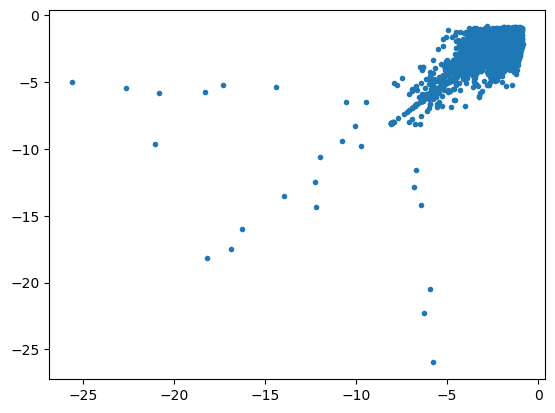

In [329]:
%matplotlib inline
s = 2
i = new_way_br.bw_parameters["lookahead_steps"].index(s)
plt.plot(new_way_br.pred_list[:,i], old_way_br.pred_list[:,i],'.')
plt.plot()
# plt.plot(new_way_br.bw_parameters["lookahead_steps"], old_way_means,'.-')
# plt.legend(["new way", "old way"])

[]

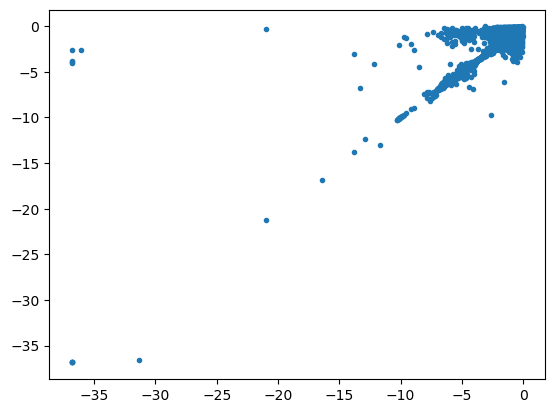

In [323]:
%matplotlib inline
s = 2
i = new_way_br.bw_parameters["lookahead_steps"].index(s)
plt.plot(new_way_br.pred_list[:,i], old_way_br.pred_list[:,i],'.')
plt.plot()
# plt.plot(new_way_br.bw_parameters["lookahead_steps"], old_way_means,'.-')
# plt.legend(["new way", "old way"])

[]

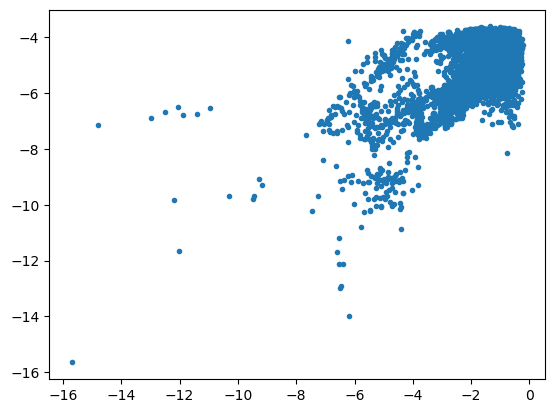

In [317]:
%matplotlib inline
s = 2
i = new_way_br.bw_parameters["lookahead_steps"].index(s)
plt.plot(new_way_br.pred_list[:,i], old_way_br.pred_list[:,i],'.')
plt.plot()
# plt.plot(new_way_br.bw_parameters["lookahead_steps"], old_way_means,'.-')
# plt.legend(["new way", "old way"])

# Old analysis

In [ ]:
run_files = []

for file in os.listdir():
    if os.path.isfile(file) and re.search("bubblewrap_run_.*\.pickle",file):
        run_files.append(file)

In [ ]:
runs = []
for file in run_files:
    with open(file, "rb") as fhan:
        br = pickle.load(fhan)
        if br.bw_parameters and "seed" not in br.bw_parameters:
            br.bw_parameters["seed"] = 42
        runs.append(br)

In [ ]:
# num, lam, nu, eps, B_thresh
columns = {}

for param in ["num", "nu", "lam", "eps", "B_thresh", "seed"]:
    columns[param] = [runs[x].bw_parameters[param] for x in range(len(runs))]


columns["ent1"] = [runs[x].entropy_list[-100:,0].mean() for x in range(len(runs))]
columns["ent10"] = [runs[x].entropy_list[-100:,1].mean() for x in range(len(runs))]
columns["pred1"] = [runs[x].pred_list[-100:,0].mean() for x in range(len(runs))]
columns["pred10"] = [runs[x].pred_list[-100:,1].mean() for x in range(len(runs))]
columns["time"] = [runs[x].time_to_run if hasattr(runs[x], "time_to_run") else None for x in range(len(runs))]

columns["file"] = [runs[x].file for x in range(len(runs))]
columns["run"] = runs
columns["location"] = run_files
fdf = pd.DataFrame(columns)

In [ ]:
unique_files = fdf.file.unique()
unique_files

array(['./generated/lorenz_1trajectories_3dim_500to20500_noise0.05.npz',
       './generated/vdp_1trajectories_2dim_500to20500_noise0.2.npz',
       './generated/lorenz_1trajectories_3dim_500to20500_noise0.2.npz',
       './generated/vdp_1trajectories_2dim_500to20500_noise0.05.npz',
       'generated/vdp_100trajectories_2dim_500to20500_noise0.2.npz',
       'generated/vdp_1trajectories_2dim_500to20500_noise0.2.npz'],
      dtype=object)

In [ ]:
df = fdf[fdf.file == unique_files[0]]

In [ ]:
correlations = df.corr(numeric_only=True)
params = ["num", "nu", "lam", "eps", "B_thresh"]
metrics = ["ent1","ent10","pred1","pred10", "time"]
param_comparison = correlations.loc[params, metrics]
param_comparison

,ent1,ent10,pred1,pred10,time
num,0.479419,0.820371,0.614206,-0.111629,0.949386
nu,-0.000744,0.014677,0.024215,0.046374,0.041001
lam,-0.048973,-0.047700,-0.018634,-0.062965,-0.055963
eps,0.573448,0.291129,-0.523616,-0.610617,0.022681
B_thresh,0.380212,0.257026,-0.019321,-0.202639,0.230475


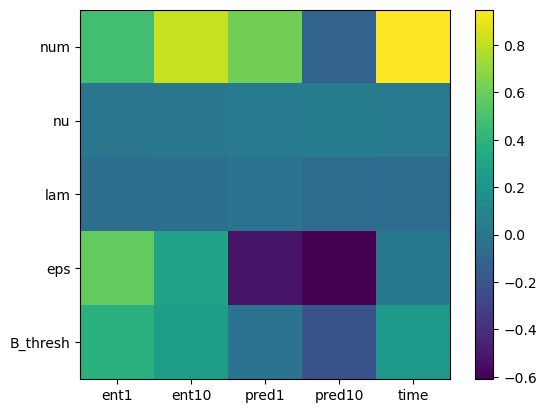

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(param_comparison)
#np.convolve(np.arange(len(metrics)+1), [.5, .5])
ax.set_xticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics)

ax.set_yticks(np.arange(len(params)))
ax.set_yticklabels(params)

fig.colorbar(im)

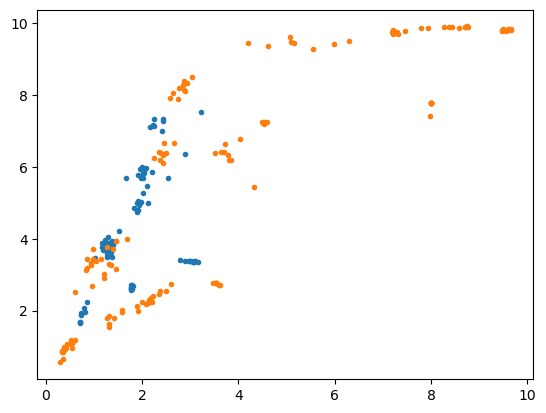

In [ ]:
mask = df.eps == .0001
a = df.ent1
b = df.ent10
plt.plot(a[mask], b[mask], '.')
plt.plot(a[~mask], b[~mask], '.')

In [ ]:
df

,num,nu,lam,eps,B_thresh,seed,ent1,ent10,pred1,pred10,time,file,run,location
0,1024,0.0010,0.0010,0.0001,-5,42,2.154670,7.117517,-6.093047,-12.112070,46.776133,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-04-23-19-59.pickle
2,16,0.0010,0.0010,0.0001,-15,42,0.822588,1.974006,-10.159780,-10.493128,16.526105,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-05-08-25-50.pickle
6,1024,0.0010,0.0001,0.0010,-10,42,2.867526,8.383525,-6.963832,-11.433135,41.378214,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-04-23-03-42.pickle
10,16,0.0010,0.0010,0.0010,-15,42,0.361579,0.840695,-10.937058,-11.063611,16.207495,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-04-23-21-43.pickle
11,1024,0.0001,0.0010,0.0010,-5,42,6.305058,9.517545,-7.644871,-11.500990,48.316343,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-05-10-02-16.pickle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,1024,0.0100,0.0001,0.0100,-10,42,8.741961,9.911880,-9.288745,-12.022569,42.979244,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-05-05-41-50.pickle
849,16,0.0100,0.0100,0.0001,-15,42,0.726606,1.871307,-10.216708,-10.486780,16.536573,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-05-06-59-11.pickle
850,16,0.0010,0.0001,0.0010,-15,390,0.364190,0.890838,-11.000175,-11.104077,16.223406,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-05-12-04-26.pickle
853,1024,0.0001,0.0100,0.0001,-5,580,2.432374,7.277180,-6.242277,-12.084297,46.838399,./generated/lorenz_1trajectories_3dim_500to205...,<scripts.run_bubblewrap.BubblewrapRun object a...,bubblewrap_run_2023-04-05-12-29-18.pickle


In [ ]:
for file in df.loc[df.iloc[:,:-2].duplicated(),"location"]:
    print(f"mv {file} duplicates")